In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
pd.set_option('display.precision', 3)
from statsmodels.stats.proportion import proportion_confint
import glob
import json
import sys


In [2]:
def check_path(path):
	if not os.path.exists(path):
		os.mkdir(path)

In [5]:
# get all data into one big csv

# Baseline: how do the models perform on the original numeric task
# dataframe with: gpt_model, sys_prompt, user_prompt, prob_type, prob_ind, correct_answer, given_answer, correct_or_not
problems = np.load('../problems/all_problems_symbols.npz', allow_pickle=True)
symb_problems = problems['all_problems'].item()

problems = np.load('../problems/all_problems.npz', allow_pickle=True)
num_problems = problems['all_problems'].item()

problems = np.load('../problems/all_problems_coords.npz', allow_pickle=True)
coord_problems = problems['all_problems'].item()

data = []
for gpt in ['350613', '0613','1106','0125']:
    for sys_prompt in [0, 1]:
        for user_prompt in [0, 1, 2]:
            for prob_format in ['coords', 'digits', 'symb']:
                if prob_format=='digits':
                    problems = num_problems
                elif prob_format=='symb':
                    problems = symb_problems
                elif prob_format == 'coords':
                    problems==coord_problems
                else:
                    print(f'prob_format is {prob_format}')
                    sys.exit()
                try:
                    gpt_data = np.load(f'../results/gpt_matprob_results_{prob_format}_{gpt}_prompt_{sys_prompt}_{user_prompt}.npz', allow_pickle=True)
                except:
                    continue
                predictions = gpt_data['all_gen_pred'].item()
                correct = gpt_data['all_gen_correct_pred'].item()
                for prob_type in predictions.keys():
                    prob_ind = 0
                    assert(len(predictions[prob_type])==len(correct[prob_type]))
                    answers = [choices[ind] for ind, choices in zip(problems[prob_type]['correct_ind'], problems[prob_type]['answer_choices'])]
                    for pred, corr, answer in zip(predictions[prob_type], correct[prob_type], answers[:len(predictions[prob_type])]):
                        if prob_format=='digits':
                            symb_num = 'num'
                        elif prob_format=='symb':
                            symb_num = 'symb'
                        elif prob_format == 'letters':
                            symb_num='lett'
                        elif prob_format=='coords':
                            symb_num = 'coords'
                        else:
                            print(f'prob_format is {prob_format}')
                        if corr:
                            corr_val = 1
                        else:
                            corr_val =0
                        
                        data.append([str(gpt), str(gpt), str(sys_prompt)+str(user_prompt),  str(symb_num), str(prob_type), prob_ind, str(answer), str(pred), corr_val, 1])
                        prob_ind += 1

gpt_df = pd.DataFrame(data=data, columns=['subj_id','model', 'promptstyle',  'symb_num', 'prob_type', 'prob_ind', 'correct_answer', 'response', 'correct', 'total'])
# save gpt data
gpt_df.to_csv('gpt_digitmat_data.csv', index=False)


In [6]:
# Human and gpt data
data_df = pd.read_csv('../all_data.csv')


In [7]:
# Set up a list of progression problem types for removal from symb problems
prog_prob_types = ['prog_size1', 'prog_size2', \
                   'two_rule_comb2', 'two_rule_comb4', 'two_rule_comb5', \
                    'three_rule_comb2', 'three_rule_comb4', 'three_rule_comb5', \
                    'three_rule_comb7', 'three_rule_comb8', 'three_rule_comb9',\
                    'AND_permuted'] # AND_permuted is not actually a progression type, but we have removed it as the answers are all spaces.

# Remove the AND_permuted problem types as these problems were not well formatted
data_df = data_df[data_df.prob_type!='AND_permuted']

data_df.prob_type.unique()


array(['XOR_permuted', 'c3_set_union_permuted', 'c2_set_union', 'attn',
       'two_rule_comb3', 'three_rule_comb3', 'two_rule_comb1',
       'row_constant', 'three_rule_comb6', 'XOR', 'AND', 'col_constant',
       'three_rule_comb1', 'two_rule_comb0', 'c1_set_union_permuted',
       'dist3_diag2', 'c3_set_union', 'three_rule_comb0', 'c1_set_union',
       'c2_set_union_permuted', 'dist3_diag1', 'prog_size2',
       'three_rule_comb8', 'two_rule_comb4', 'three_rule_comb2',
       'three_rule_comb7', 'three_rule_comb9', 'prog_size1',
       'two_rule_comb5', 'two_rule_comb2', 'three_rule_comb5',
       'three_rule_comb4'], dtype=object)

In [9]:
# Create coarse problem types

const = ['row_constant', 'col_constant']
dist3 = ['dist3_diag1', 'dist3_diag2']
prog = ['prog_size1', 'prog_size2']
logic_unperm = ['c3_set_union', 'c1_set_union', 'c2_set_union', 'AND', 'XOR']
logic_perm = ['c3_set_union_permuted', 'c2_set_union_permuted','c1_set_union_permuted', 'XOR_permuted', 'AND_permuted'] # Removed AND_permuted

two_rule = ['two_rule_comb0', 'two_rule_comb1', 'two_rule_comb3']
prog_two_rule = [ 'two_rule_comb2', 'two_rule_comb4', 'two_rule_comb5']
three_rule =['three_rule_comb0', 'three_rule_comb1', \
             'three_rule_comb3', 'three_rule_comb6']
prog_three_rule = ['three_rule_comb2', 'three_rule_comb4', 'three_rule_comb5',\
       'three_rule_comb7', 'three_rule_comb8', 'three_rule_comb9']
attn=['attn']

conditions = [data_df.prob_type.isin(const),\
              data_df.prob_type.isin(dist3),\
              data_df.prob_type.isin(prog),\
              data_df.prob_type.isin(two_rule),\
              data_df.prob_type.isin(prog_two_rule),\
              data_df.prob_type.isin(three_rule),\
              data_df.prob_type.isin(prog_three_rule),\
              data_df.prob_type.isin(logic_unperm),\
              data_df.prob_type.isin(logic_perm),\
              data_df.prob_type.isin(attn)]

choices = ['const', 'dist3', 'prog', 'two_rule', 'prog_two_rule', 'three_rule', 'prog_three_rule', 'logic_unperm', 'logic_perm', 'attn']

coarse_types = np.select(conditions, choices, default='wrong!')
print(f'There are {len(coarse_types[coarse_types=="wrong!"])} datapoints without a coarse type')
assert len(coarse_types)==len(data_df)

data_df['coarse_type'] = np.select(conditions, choices)


There are 0 datapoints without a coarse type


In [10]:
# Create even coarser problem types

one_rule = ['row_constant', 'col_constant', 'dist3_diag1', 'dist3_diag2', 'prog_size1', 'prog_size2']
logic= ['c3_set_union', 'c1_set_union', 'c2_set_union', 'AND', 'XOR', 'c3_set_union_permuted', 'c2_set_union_permuted','c1_set_union_permuted', 'XOR_permuted', 'AND_permuted'] # Removed AND_permuted

two_rule = ['two_rule_comb0', 'two_rule_comb1', 'two_rule_comb3', 'two_rule_comb2', 'two_rule_comb4', 'two_rule_comb5']
three_rule =['three_rule_comb0', 'three_rule_comb1', 'three_rule_comb2', 'three_rule_comb3',\
              'three_rule_comb4', 'three_rule_comb5', 'three_rule_comb6',\
              'three_rule_comb7', 'three_rule_comb8', 'three_rule_comb9']
attn=['attn']

conditions = [data_df.prob_type.isin(one_rule),\
              data_df.prob_type.isin(two_rule),\
              data_df.prob_type.isin(three_rule),\
              data_df.prob_type.isin(logic),\
              data_df.prob_type.isin(attn)]

choices = ['one_rule', 'two_rule', 'three_rule', 'logic', 'attn']

coarse_types = np.select(conditions, choices, default='wrong!')
print(f'There are {len(coarse_types[coarse_types=="wrong!"])} datapoints without a coarser type')
assert len(coarse_types)==len(data_df)

data_df['coarse_type_2'] = np.select(conditions, choices)

data_df = data_df[data_df.prob_type!='attn']



There are 0 datapoints without a coarser type


In [11]:
# Headline results
current_df = data_df[((data_df.promptstyle=='12')|(data_df.promptstyle=='human'))&\
                     ((data_df.symb_num!='symb')|(~data_df.coarse_type.isin(['prog','prog_two_rule','prog_three_rule'])))]
current_df = current_df.groupby(['model', 'promptstyle', 'symb_num'], as_index=False).sum()
current_df['model'] = pd.Categorical(current_df['model'], ordered = True, categories = ['human', '350613', '0613', '1106', '0125'])
current_df['symb_num'] = pd.Categorical(current_df['symb_num'], ordered = True, categories = ['num', 'coords', 'symb', 'lett'])
current_df = current_df.sort_values(['model', 'symb_num'])

current_df['acc'] = current_df.correct/current_df.total
current_df['cilow'] = proportion_confint(current_df.correct, current_df.total)[0]
current_df['ciupp'] = proportion_confint(current_df.correct, current_df.total)[1]
current_df['yerr_low'] = current_df.acc-current_df.cilow
current_df['yerr_upp'] = current_df.ciupp-current_df.acc

for model in ['human', '350613', '0613']:
    df_slice = current_df[(current_df.model==model)&(current_df.symb_num!='lett')&\
                        ((current_df.promptstyle=='human') | (current_df.promptstyle=='12'))]
    print(model)
    print(df_slice[['symb_num', 'acc', 'cilow', 'ciupp', 'total']])

human
   symb_num    acc  cilow  ciupp   total
11      num  0.715  0.693  0.738  1550.0
10   coords  0.771  0.745  0.797  1000.0
12     symb  0.704  0.676  0.732  1000.0
350613
  symb_num    acc  cilow  ciupp   total
8      num  0.813  0.799  0.827  2916.0
7   coords  0.480  0.455  0.506  1466.0
9     symb  0.790  0.772  0.808  2000.0
0613
  symb_num    acc  cilow  ciupp   total
3      num  0.810  0.796  0.824  2916.0
2   coords  0.477  0.452  0.503  1466.0
4     symb  0.792  0.774  0.810  2000.0


[306.0, 297.0, 502.0, 445.0]


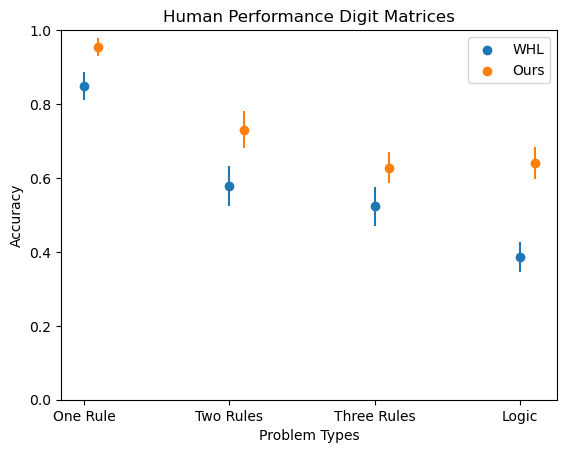

In [13]:
# Comparison of human performance us vs Webb et al
current_df = data_df.groupby(['model', 'promptstyle', 'symb_num', 'coarse_type_2'], as_index=False).sum()
current_df['model'] = pd.Categorical(current_df['model'], ordered = True, categories = ['human', '350613', '0613', '1106', '0125'])
current_df['symb_num'] = pd.Categorical(current_df['symb_num'], ordered = True, categories = ['num', 'symb', 'lett'])
current_df['coarse_type_2'] = pd.Categorical(current_df['coarse_type_2'], ordered = True, categories = ['one_rule', 'two_rule', 'three_rule', 'logic'])
current_df = current_df.sort_values(['model', 'symb_num', 'coarse_type_2'])

fig, ax = plt.subplots()
current_df['acc'] = current_df.correct/current_df.total
current_df['cilow'] = proportion_confint(current_df.correct, current_df.total)[0]
current_df['ciupp'] = proportion_confint(current_df.correct, current_df.total)[1]
current_df['yerr_low'] = current_df.acc-current_df.cilow
current_df['yerr_upp'] = current_df.ciupp-current_df.acc

webb_human = np.load('../results/webb_original/probcat_gen_acc_behavior.npz')
accs = webb_human['acc']
errs = webb_human['err']

scat = ax.scatter(np.arange(len(accs)), accs)
ax.errorbar(np.arange(len(accs)), accs, yerr=errs, ls='none', color=scat.get_facecolors()[-1])

df_slice = current_df[(current_df.model =='human')&(current_df.symb_num=='num')]
accs = list(df_slice.acc)
yerr_low = list(df_slice.yerr_low)
yerr_upp = list(df_slice.yerr_upp)
print(list(df_slice.total))

scat = ax.scatter(np.arange(len(accs))+0.1, accs)
ax.errorbar(np.arange(len(accs))+0.1, accs, yerr=[yerr_low, yerr_upp], ls='none', color=scat.get_facecolors()[-1])

ax.set_xticks(range(len(accs)))
ax.set_xticklabels(['One Rule', 'Two Rules', 'Three Rules', 'Logic'])
ax.set_ylim([0, 1])
ax.set_xlabel('Problem Types')
ax.set_ylabel('Accuracy')
plt.legend(['WHL', 'Ours'])
ax.set_title('Human Performance Digit Matrices')

plt.savefig('human_digit_webb.pdf')



[[0.         0.04465213 0.04522208 0.03919928]
 [0.         0.04465213 0.04522208 0.03919928]]
Model: 350613
      acc   total
65  1.000   416.0
67  0.883   600.0
66  0.691  1000.0
64  0.816   900.0
Model: 0613
      acc   total
29  1.000   416.0
31  0.882   600.0
30  0.684  1000.0
28  0.814   900.0


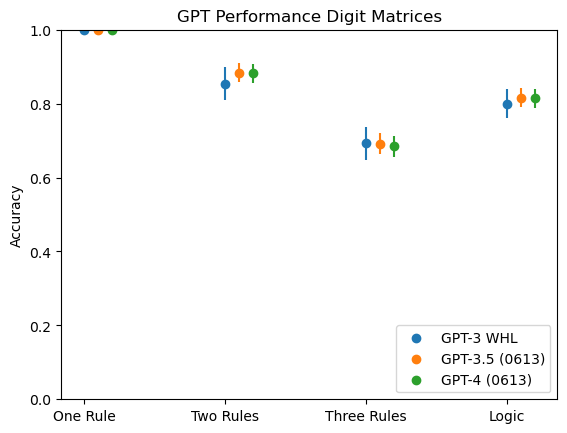

In [ ]:
# Webb GPT3 vs us

current_df = data_df
current_df = current_df.groupby(['model', 'promptstyle', 'symb_num', 'coarse_type_2'], as_index=False).sum()
current_df = current_df[current_df.promptstyle=='12']
current_df['model'] = pd.Categorical(current_df['model'], ordered = True, categories = ['human', '350613', '0613', '1106', '0125'])
current_df['symb_num'] = pd.Categorical(current_df['symb_num'], ordered = True, categories = ['num', 'symb', 'coords' 'lett'])
current_df['coarse_type_2'] = pd.Categorical(current_df['coarse_type_2'], ordered = True, categories = ['one_rule', 'two_rule', 'three_rule', 'logic'])
current_df = current_df.sort_values(['model', 'symb_num','coarse_type_2'])

webb_gpt = np.load('../results/webb_original/all_probcat_gen_acc.npz')
accs = webb_gpt['acc']
errs = webb_gpt['err']

fig, ax = plt.subplots()

scat = ax.scatter(np.arange(len(accs)), accs)
ax.errorbar(np.arange(len(accs)), accs, yerr=errs, ls='none', color=scat.get_facecolors()[-1])
    

current_df['acc'] = current_df.correct/current_df.total
current_df['cilow'] = proportion_confint(current_df.correct, current_df.total)[0]
current_df['ciupp'] = proportion_confint(current_df.correct, current_df.total)[1]
current_df['yerr_low'] = current_df.acc-current_df.cilow
current_df['yerr_upp'] = current_df.ciupp-current_df.acc


for i, model in enumerate(['350613', '0613']):
    df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='num')]
    # print(df_slice.correct)
    # print(df_slice.head())
    accs = list(df_slice.acc)
    print(f'Model: {model}')
    print(df_slice[['acc', 'total']])
    yerr_low = list(df_slice.yerr_low)
    yerr_upp = list(df_slice.yerr_upp)
    scat = ax.scatter(np.arange(len(accs))+(i+1)*0.1, accs)
    ax.errorbar(np.arange(len(accs))+(i+1)*0.1, accs, yerr=[yerr_low, yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    ax.set_xticks(range(len(accs)))
    ax.set_xticklabels(['One Rule', 'Two Rules', 'Three Rules', 'Logic'])
ax.set_ylim([0, 1])
ax.set_ylabel('Accuracy')
ax.legend(['GPT-3 WHL', 'GPT-3.5 (0613)', 'GPT-4 (0613)'], loc='lower right')

ax.set_title('GPT Performance Digit Matrices')

plt.savefig('gpt_digit_webb.pdf')

['XOR_permuted' 'c3_set_union_permuted' 'c2_set_union' 'two_rule_comb3'
 'three_rule_comb3' 'two_rule_comb1' 'row_constant' 'three_rule_comb6'
 'XOR' 'AND' 'col_constant' 'three_rule_comb1' 'two_rule_comb0'
 'c1_set_union_permuted' 'dist3_diag2' 'c3_set_union' 'three_rule_comb0'
 'c1_set_union' 'c2_set_union_permuted' 'dist3_diag1']
Model: human
      acc  total
77  1.000  206.0
79  0.816  147.0
78  0.683  202.0
76  0.640  445.0
Model: human
      acc  total
81  0.985  205.0
83  0.711  149.0
82  0.551  205.0
80  0.642  441.0
Model: 350613
      acc  total
69  0.990  400.0
71  0.897  300.0
70  0.715  400.0
68  0.699  900.0
Model: 0613
      acc  total
33  0.993  400.0
35  0.900  300.0
34  0.720  400.0
32  0.699  900.0


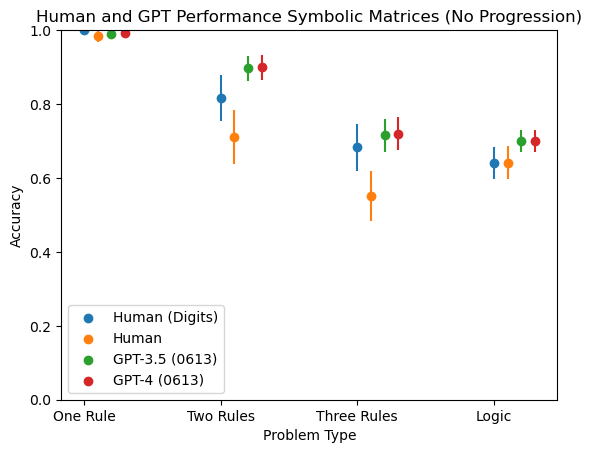

In [17]:
# Symbolic plot

# Removing progression types as symbolic problems do not have progression

current_df = data_df[~data_df.coarse_type.isin(['prog','prog_two_rule','prog_three_rule'])]
print(current_df.prob_type.unique())

current_df = current_df.groupby(['model', 'promptstyle', 'symb_num', 'coarse_type_2'], as_index=False).sum()
current_df = current_df[((current_df.promptstyle=='12')|(current_df.promptstyle=='human'))]
current_df['model'] = pd.Categorical(current_df['model'], ordered = True, categories = ['human', '350613', '0613', '1106', '0125'])
current_df['symb_num'] = pd.Categorical(current_df['symb_num'], ordered = True, categories = ['num', 'symb', 'lett', 'coords'])
current_df['coarse_type_2'] = pd.Categorical(current_df['coarse_type_2'], ordered = True, categories = ['one_rule', 'two_rule', 'three_rule', 'logic'])
current_df = current_df.sort_values(['model', 'symb_num', 'coarse_type_2'])


fig, ax = plt.subplots()
current_df['acc'] = current_df.correct/current_df.total
current_df['cilow'] = proportion_confint(current_df.correct, current_df.total)[0]
current_df['ciupp'] = proportion_confint(current_df.correct, current_df.total)[1]
current_df['yerr_low'] = current_df.acc-current_df.cilow
current_df['yerr_upp'] = current_df.ciupp-current_df.acc


for i, model in enumerate(['human','human','350613', '0613']):
    if i==0: 
        df_slice=current_df[(current_df.model==model)&(current_df.symb_num=='num')]
    else:
        df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='symb')]

    accs = list(df_slice.acc)
    print(f'Model: {model}')
    print(df_slice[['acc', 'total']])
    yerr_low = list(df_slice.yerr_low)
    yerr_upp = list(df_slice.yerr_upp)
    scat = ax.scatter(np.arange(len(accs))+i*0.1, accs)
    ax.errorbar(np.arange(len(accs))+i*0.1, accs, yerr=[yerr_low, yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['One Rule', 'Two Rules', 'Three Rules', 'Logic'])
ax.set_ylim([0, 1])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Problem Type')
ax.legend(['Human (Digits)', 'Human', 'GPT-3.5 (0613)', 'GPT-4 (0613)'], loc='lower left')

ax.set_title('Human and GPT Performance Symbolic Matrices (No Progression)')

plt.savefig('symbol_matrices_gpt_human.pdf')

Model: human
      acc  total
77  0.954  306.0
79  0.731  297.0
78  0.627  502.0
76  0.640  445.0
Model: human
      acc  total
73  0.971  208.0
75  0.797  182.0
74  0.686  299.0
72  0.704  311.0
Model: 350613
      acc  total
61  0.731  216.0
63  0.560  300.0
62  0.454  500.0
60  0.336  450.0
Model: 0613
      acc  total
25  0.736  216.0
27  0.563  300.0
26  0.442  500.0
24  0.336  450.0


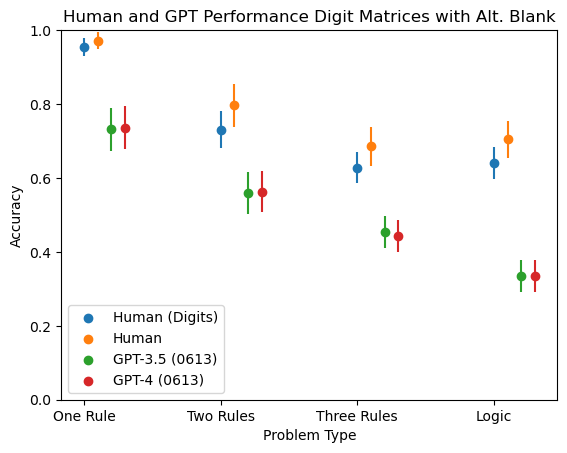

In [18]:
# Coords plot

current_df = data_df.groupby(['model', 'promptstyle', 'symb_num', 'coarse_type_2'], as_index=False).sum()
current_df = current_df[((current_df.promptstyle=='12')|(current_df.promptstyle=='human'))]
current_df['model'] = pd.Categorical(current_df['model'], ordered = True, categories = ['human', '350613', '0613', '1106', '0125'])
current_df['symb_num'] = pd.Categorical(current_df['symb_num'], ordered = True, categories = ['num', 'symb', 'lett', 'coords'])
current_df['coarse_type_2'] = pd.Categorical(current_df['coarse_type_2'], ordered = True, categories = ['one_rule', 'two_rule', 'three_rule', 'logic'])
current_df = current_df.sort_values(['model', 'symb_num', 'coarse_type_2'])


fig, ax = plt.subplots()
current_df['acc'] = current_df.correct/current_df.total
current_df['cilow'] = proportion_confint(current_df.correct, current_df.total)[0]
current_df['ciupp'] = proportion_confint(current_df.correct, current_df.total)[1]
current_df['yerr_low'] = current_df.acc-current_df.cilow
current_df['yerr_upp'] = current_df.ciupp-current_df.acc


for i, model in enumerate(['human', 'human', '350613', '0613']):
    if i == 0:
        df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='num')]
    else:
        df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='coords')]
    accs = list(df_slice.acc)
    print(f'Model: {model}')
    print(df_slice[['acc', 'total']])
    yerr_low = list(df_slice.yerr_low)
    yerr_upp = list(df_slice.yerr_upp)
    scat = ax.scatter(np.arange(len(accs))+i*0.1, accs)
    ax.errorbar(np.arange(len(accs))+i*0.1, accs, yerr=[yerr_low, yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['One Rule', 'Two Rules', 'Three Rules', 'Logic'])
ax.set_ylim([0, 1])
ax.legend(['Human (Digits)', 'Human', 'GPT-3.5 (0613)', 'GPT-4 (0613)'], loc='lower left')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Problem Type')

ax.set_title('Human and GPT Performance Digit Matrices with Alt. Blank')

plt.savefig('digit_alt_blank.pdf')

Model: human
      acc  total
77  0.954  306.0
79  0.731  297.0
78  0.627  502.0
76  0.640  445.0
Model: human
      acc  total
73  0.971  208.0
75  0.797  182.0
74  0.686  299.0
72  0.704  311.0


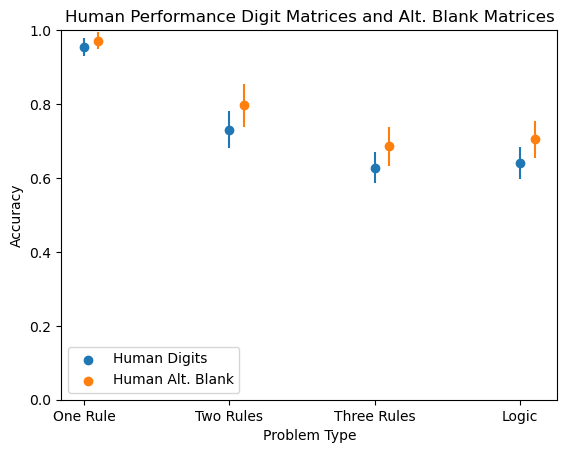

In [21]:
# Human performance coords problems
current_df = data_df.groupby(['model', 'promptstyle', 'symb_num', 'coarse_type_2'], as_index=False).sum()
current_df = current_df[((current_df.promptstyle=='12')|(current_df.promptstyle=='human'))]
current_df['model'] = pd.Categorical(current_df['model'], ordered = True, categories = ['human', '350613', '0613', '1106', '0125'])
current_df['symb_num'] = pd.Categorical(current_df['symb_num'], ordered = True, categories = ['num', 'symb', 'lett', 'coords'])
current_df['coarse_type_2'] = pd.Categorical(current_df['coarse_type_2'], ordered = True, categories = ['one_rule', 'two_rule', 'three_rule', 'logic'])
current_df = current_df.sort_values(['model', 'symb_num', 'coarse_type_2'])


fig, ax = plt.subplots()
current_df['acc'] = current_df.correct/current_df.total
current_df['cilow'] = proportion_confint(current_df.correct, current_df.total)[0]
current_df['ciupp'] = proportion_confint(current_df.correct, current_df.total)[1]
current_df['yerr_low'] = current_df.acc-current_df.cilow
current_df['yerr_upp'] = current_df.ciupp-current_df.acc


for i, model in enumerate(['human', 'human']):
    if i == 0:
        df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='num')]
    else:
        df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='coords')]

    accs = list(df_slice.acc)
    print(f'Model: {model}')
    print(df_slice[['acc', 'total']])
    yerr_low = list(df_slice.yerr_low)
    yerr_upp = list(df_slice.yerr_upp)
    scat = ax.scatter(np.arange(len(accs))+i*0.1, accs)
    ax.errorbar(np.arange(len(accs))+i*0.1, accs, yerr=[yerr_low, yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['One Rule', 'Two Rules', 'Three Rules', 'Logic'])
ax.set_ylim([0, 1])
ax.legend(['Human Digits', 'Human Alt. Blank'], loc='lower left')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Problem Type')

ax.set_title('Human Performance Digit Matrices and Alt. Blank Matrices')

plt.savefig('human_digit_alt_blank.pdf')

Model: human
      acc  total
77  1.000  206.0
79  0.816  147.0
78  0.683  202.0
76  0.640  445.0
Model: human
      acc  total
81  0.985  205.0
83  0.711  149.0
82  0.551  205.0
80  0.642  441.0


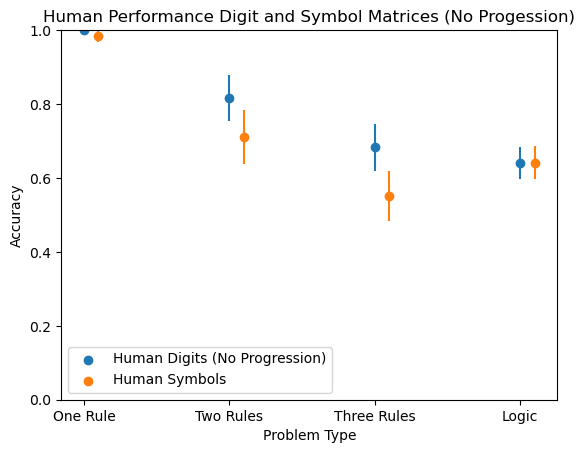

In [22]:
# Human performance symbol problems

# remove progression problems (shouldn't be any for humans)
current_df = data_df[~data_df.coarse_type.isin(['prog','prog_two_rule','prog_three_rule'])]
current_df = current_df.groupby(['model', 'promptstyle', 'symb_num', 'coarse_type_2'], as_index=False).sum()
current_df = current_df[((current_df.promptstyle=='12')|(current_df.promptstyle=='human'))]
current_df['model'] = pd.Categorical(current_df['model'], ordered = True, categories = ['human', '350613', '0613', '1106', '0125'])
current_df['symb_num'] = pd.Categorical(current_df['symb_num'], ordered = True, categories = ['num', 'symb', 'lett', 'coords'])
current_df['coarse_type_2'] = pd.Categorical(current_df['coarse_type_2'], ordered = True, categories = ['one_rule', 'two_rule', 'three_rule', 'logic'])
current_df = current_df.sort_values(['model', 'symb_num', 'coarse_type_2'])


fig, ax = plt.subplots()
current_df['acc'] = current_df.correct/current_df.total
current_df['cilow'] = proportion_confint(current_df.correct, current_df.total)[0]
current_df['ciupp'] = proportion_confint(current_df.correct, current_df.total)[1]
current_df['yerr_low'] = current_df.acc-current_df.cilow
current_df['yerr_upp'] = current_df.ciupp-current_df.acc


for i, model in enumerate(['human', 'human']):
    if i == 0:
        df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='num')]
    else:
        df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='symb')]
    accs = list(df_slice.acc)
    print(f'Model: {model}')
    print(df_slice[['acc', 'total']])
    yerr_low = list(df_slice.yerr_low)
    yerr_upp = list(df_slice.yerr_upp)
    scat = ax.scatter(np.arange(len(accs))+i*0.1, accs)
    ax.errorbar(np.arange(len(accs))+i*0.1, accs, yerr=[yerr_low, yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['One Rule', 'Two Rules', 'Three Rules', 'Logic'])
ax.set_ylim([0, 1])
ax.legend(['Human Digits (No Progression)', 'Human Symbols'], loc='lower left')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Problem Type')

ax.set_title('Human Performance Digit and Symbol Matrices (No Progession)')

plt.savefig('human_digit_symbols.pdf')

Model: 350613
      acc   total
65  1.000   416.0
67  0.883   600.0
66  0.691  1000.0
64  0.816   900.0
Model: 350613
      acc  total
61  0.731  216.0
63  0.560  300.0
62  0.454  500.0
60  0.336  450.0
Model: 0613
      acc   total
29  1.000   416.0
31  0.882   600.0
30  0.684  1000.0
28  0.814   900.0
Model: 0613
      acc  total
25  0.736  216.0
27  0.563  300.0
26  0.442  500.0
24  0.336  450.0


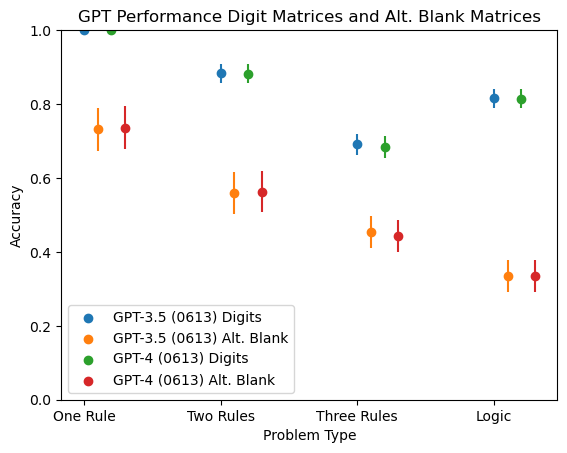

In [23]:
# GPT performance coords problems

current_df = data_df.groupby(['model', 'promptstyle', 'symb_num', 'coarse_type_2'], as_index=False).sum()
current_df = current_df[((current_df.promptstyle=='12')|(current_df.promptstyle=='human'))]
current_df['model'] = pd.Categorical(current_df['model'], ordered = True, categories = ['human', '350613', '0613', '1106', '0125'])
current_df['symb_num'] = pd.Categorical(current_df['symb_num'], ordered = True, categories = ['num', 'symb', 'lett', 'coords'])
current_df['coarse_type_2'] = pd.Categorical(current_df['coarse_type_2'], ordered = True, categories = ['one_rule', 'two_rule', 'three_rule', 'logic'])
current_df = current_df.sort_values(['model', 'symb_num', 'coarse_type_2'])


fig, ax = plt.subplots()
current_df['acc'] = current_df.correct/current_df.total
current_df['cilow'] = proportion_confint(current_df.correct, current_df.total)[0]
current_df['ciupp'] = proportion_confint(current_df.correct, current_df.total)[1]
current_df['yerr_low'] = current_df.acc-current_df.cilow
current_df['yerr_upp'] = current_df.ciupp-current_df.acc


for i, model in enumerate(['350613', '350613', '0613', '0613']):
    if i%2==0:
        df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='num')]
    else:
        df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='coords')]
    accs = list(df_slice.acc)
    print(f'Model: {model}')
    print(df_slice[['acc', 'total']])
    yerr_low = list(df_slice.yerr_low)
    yerr_upp = list(df_slice.yerr_upp)
    scat = ax.scatter(np.arange(len(accs))+i*0.1, accs)
    ax.errorbar(np.arange(len(accs))+i*0.1, accs, yerr=[yerr_low, yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['One Rule', 'Two Rules', 'Three Rules', 'Logic'])
ax.set_ylim([0, 1])
ax.legend(['GPT-3.5 (0613) Digits','GPT-3.5 (0613) Alt. Blank',  'GPT-4 (0613) Digits','GPT-4 (0613) Alt. Blank'], loc='lower left')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Problem Type')

ax.set_title('GPT Performance Digit Matrices and Alt. Blank Matrices')

plt.savefig('gpt_digit_alt_blank.pdf')

Model: 350613
      acc  total
65  1.000  400.0
67  0.897  300.0
66  0.730  400.0
64  0.816  900.0
Model: 350613
      acc  total
69  0.990  400.0
71  0.897  300.0
70  0.715  400.0
68  0.699  900.0
Model: 0613
      acc  total
29  1.000  400.0
31  0.887  300.0
30  0.718  400.0
28  0.814  900.0
Model: 0613
      acc  total
33  0.993  400.0
35  0.900  300.0
34  0.720  400.0
32  0.699  900.0


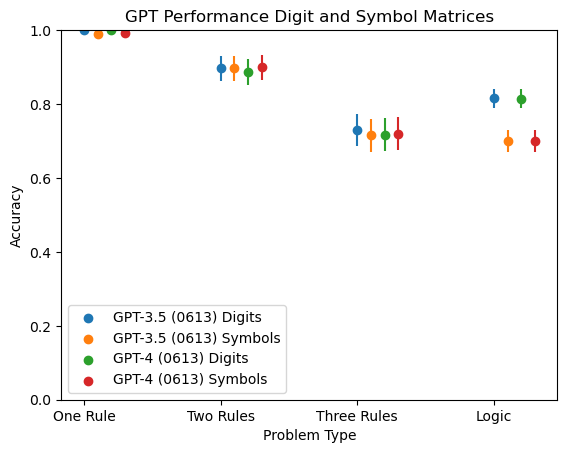

In [24]:
# GPT performance Symbol problems

current_df = data_df[~data_df.coarse_type.isin(['prog','prog_two_rule','prog_three_rule'])]
current_df = current_df.groupby(['model', 'promptstyle', 'symb_num', 'coarse_type_2'], as_index=False).sum()
current_df = current_df[((current_df.promptstyle=='12')|(current_df.promptstyle=='human'))]
current_df['model'] = pd.Categorical(current_df['model'], ordered = True, categories = ['human', '350613', '0613', '1106', '0125'])
current_df['symb_num'] = pd.Categorical(current_df['symb_num'], ordered = True, categories = ['num', 'symb', 'lett', 'coords'])
current_df['coarse_type_2'] = pd.Categorical(current_df['coarse_type_2'], ordered = True, categories = ['one_rule', 'two_rule', 'three_rule', 'logic'])
current_df = current_df.sort_values(['model', 'symb_num', 'coarse_type_2'])

fig, ax = plt.subplots()
current_df['acc'] = current_df.correct/current_df.total
current_df['cilow'] = proportion_confint(current_df.correct, current_df.total)[0]
current_df['ciupp'] = proportion_confint(current_df.correct, current_df.total)[1]
current_df['yerr_low'] = current_df.acc-current_df.cilow
current_df['yerr_upp'] = current_df.ciupp-current_df.acc


for i, model in enumerate(['350613',  '350613', '0613', '0613']):
    if i%2 ==0:
        df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='num')]
    else:
        df_slice = current_df[(current_df.model==model)&(current_df.symb_num=='symb')]
    accs = list(df_slice.acc)
    print(f'Model: {model}')
    print(df_slice[['acc', 'total']])
    yerr_low = list(df_slice.yerr_low)
    yerr_upp = list(df_slice.yerr_upp)
    scat = ax.scatter(np.arange(len(accs))+i*0.1, accs)
    ax.errorbar(np.arange(len(accs))+i*0.1, accs, yerr=[yerr_low, yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['One Rule', 'Two Rules', 'Three Rules', 'Logic'])
ax.set_ylim([0, 1])
ax.legend(['GPT-3.5 (0613) Digits','GPT-3.5 (0613) Symbols',  'GPT-4 (0613) Digits','GPT-4 (0613) Symbols'], loc='lower left')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Problem Type')

ax.set_title('GPT Performance Digit and Symbol Matrices')

plt.savefig('gpt_digit_symbols.pdf')